# Relationship Between Goals Scored and Transfer Market Value
#### Abraham Austin, Samuel McIlrath, Francisco Rodriguez Sanchez | MATH 263
##### April 24, 2025

## Introduction
### Topic:
For our project, we will explore soccer player's transfer market values. In professional soccer,
a player's transfer value represents the estimated fee one club must pay another to acquire a player.
While many factors go into a player’s price, we want to look at the relationship between a player's attacking stats in a season and their transfer values. The specific stats that we will be looking at are: goals, assists, expected goals, expected assists, total shots per 90 minutes of game time, shots on target percentage, and dribbles completed percentage.

### Data:
Our sample data comes from the Kaggle dataset found at:
https://www.kaggle.com/datasets/kriegsmaschine/soccer-players-values-and-their-statistics
This dataset contains the player values and statistics of players for the 2017/2018 season but
we will be looking specifically at players who are classified in attacking positions. This dataset is a compilation of information from transfermarkt.de and fbref.com which provide very in depth soccer statistics for players across the top 5 leagues. Before we can engage and tackle our problem we need to clean up the dataset so that we are only working with the information that is relevant to our research. This included ensuring unique samples, grabbing only players that identified as attackers, as well as dropping columns that aren't associated with actions typical for attackers (defensive play).

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [29]:
# load csv to dataframe
df = pd.read_csv("raw/transfermarkt_fbref_201718.csv", sep = ';')

#rename first column to id
if df.columns[0] == '' or df.columns[0].startswith('Unnamed'):
    df = df.rename(columns={df.columns[0]: 'id'})

In [30]:
n_obs = len(df)
n_unique_ids = df['id'].nunique()
print(f"Total observations: {n_obs}")
print(f"Unique IDs:        {n_unique_ids}")
assert n_obs == n_unique_ids, "some IDs are not unique!"

Total observations: 2232
Unique IDs:        2232


## Exploratory Data Analysis
After selecting only players whose position contains “FW” (forward), we’re left with 825 entries. There’s a huge range of talent here in the data set. For example there are squad players who barely see the pitch to ultra-expensive stars like Lionel Messi. Players’ transfer values span from under €1 M all the way up to nearly €180 M. Goal totals range from 0 to 34 (though most forwards fall below 10 goals). This extreme right-skew in both price and production will be most evident in out boxplots. So, we will visualize each distribution before calculating correlations and performing a regression.

In [47]:
#Get only the attacking players
fw_players = df[df['position'].str.contains("FW", na=False)]

season_minutes = 38*90
cutoff = 0.25*season_minutes
fw_players = fw_players[fw_players["minutes"] >= cutoff]

fw_obs = len(fw_players)
print(f"Total FW observations: {fw_obs}")

#get attacking stats columns))
result = fw_players[["player", "goals","assists", "xg", "xa", "shots_total_per90", "shots_on_target_pct", "dribbles_completed_pct","value"]]
print("\nDescriptive statistics for attacking players:\n", result.describe().T)


Total FW observations: 473

Descriptive statistics for attacking players:
                         count          mean           std       min  \
goals                   473.0  5.885835e+00  5.612455e+00      0.00   
assists                 473.0  3.086681e+00  2.665475e+00      0.00   
xg                      473.0  5.699789e+00  4.552921e+00      0.40   
xa                      473.0  3.062791e+00  2.263306e+00      0.20   
shots_total_per90       473.0  2.188140e+00  8.567065e-01      0.42   
shots_on_target_pct     473.0  3.633911e+01  9.456948e+00      0.00   
dribbles_completed_pct  473.0  5.741564e+01  1.244694e+01      0.00   
value                   473.0  1.794181e+07  2.622994e+07  25000.00   

                              25%         50%          75%           max  
goals                         2.0        4.00         8.00  3.400000e+01  
assists                       1.0        2.00         5.00  1.500000e+01  
xg                            2.6        4.40         7.70  

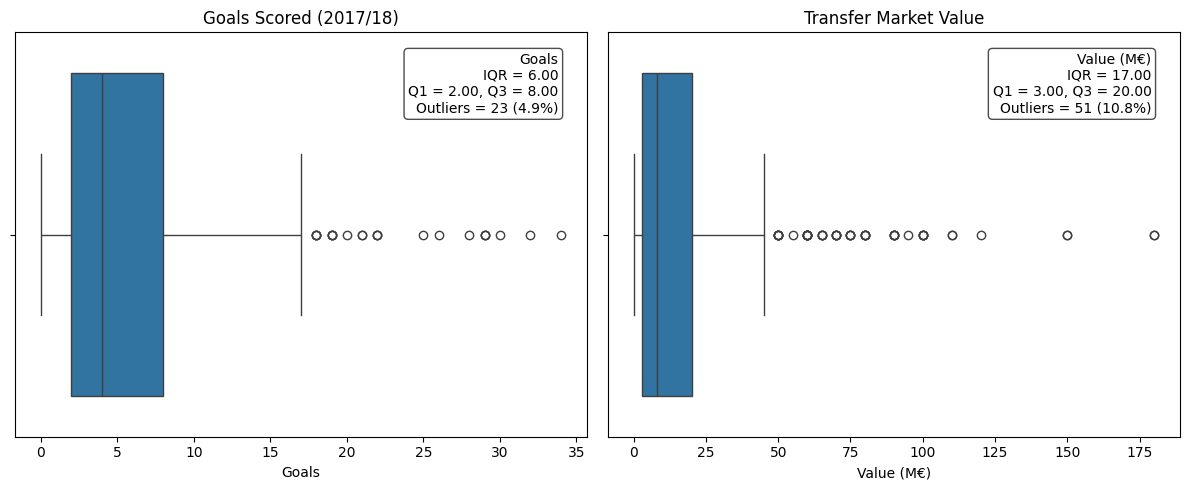

In [48]:
fw = fw_players.copy()
fw['value_m_eur'] = fw['value'] / 1e6

# helper to compute stats and annotate
def annotate_box(ax, data, label):
    q1, q3 = np.quantile(data, [0.25, 0.75])
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    # count outliers
    is_out = (data < lower_fence) | (data > upper_fence)
    n_out = is_out.sum()
    pct_out = 100 * n_out / len(data)
    
    # annotate on the plot
    text = (
        f"{label}\n"
        f"IQR = {iqr:.2f}\n"
        f"Q1 = {q1:.2f}, Q3 = {q3:.2f}\n"
        f"Outliers = {n_out} ({pct_out:.1f}%)"
    )
    # place text in upper right of the axes
    ax.text(
        0.95, 0.95, text,
        transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
    )

# create side-by-side boxplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# goals
sns.boxplot(x=fw['goals'], ax=ax1)
ax1.set_title("Goals Scored (2017/18)")
ax1.set_xlabel("Goals")
annotate_box(ax1, fw['goals'], "Goals")

# transfer value
sns.boxplot(x=fw['value_m_eur'], ax=ax2)
ax2.set_title("Transfer Market Value")
ax2.set_xlabel("Value (M€)")
annotate_box(ax2, fw['value_m_eur'], "Value (M€)")

plt.tight_layout()
plt.show()

#### Goals Scored:
- IQR = 5
- Outlier Presence = 50 (6.1%)

#### Transfer Market Value (Millions of Euros):
- IQR = 10.5
- Outlier Presence = 92 (11.2%)

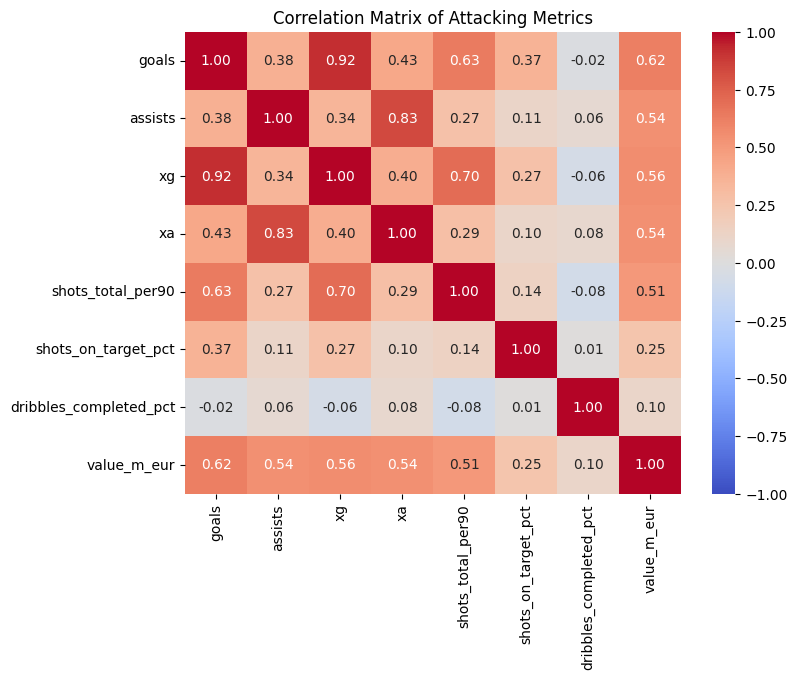

In [49]:
cols = ["goals", "assists", "xg", "xa", "shots_total_per90", "shots_on_target_pct", "dribbles_completed_pct", "value_m_eur"]
corr = fw[cols].corr()
plt.figure(figsize=(8,6))
#https://stackoverflow.com/questions/65988614/visualizing-a-huge-correlation-matrix-in-python citation
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Attacking Metrics")
plt.show()

#### Correlation Coefficient
- Goals to Transfer Market Value = 0.64

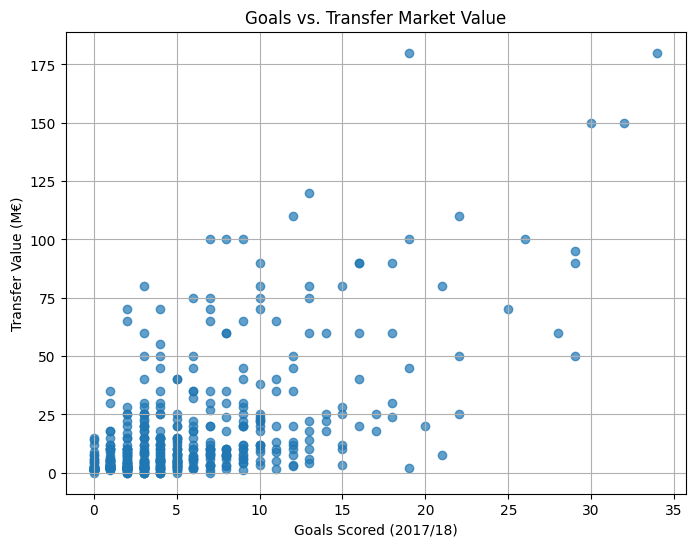

In [50]:
plt.figure(figsize=(8,6))
plt.scatter(fw["goals"], fw["value_m_eur"], alpha=0.7)
plt.xlabel("Goals Scored (2017/18)")
plt.ylabel("Transfer Value (M€)")
plt.title("Goals vs. Transfer Market Value")
plt.grid(True)
plt.show()

#### Graphical Relationship
Here we can see a generally positive relationship between Goals Scored and Transfer Value

Slope: 2.92
Intercept: 0.76
Correlation coefficient (r): 0.62
Coefficient of determination (r^2): 0.39


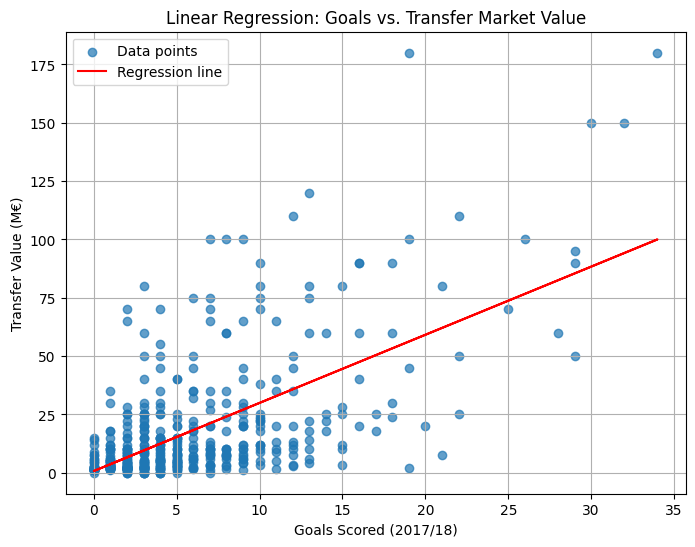

In [78]:
from scipy.stats import linregress

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(fw['goals'], fw['value_m_eur'])

# Calculate r^2
r_squared = r_value**2

# Display the regression results
print(f"Slope: {slope:.2f}")
print(f"Intercept: {intercept:.2f}")
print(f"Correlation coefficient (r): {r_value:.2f}")
print(f"Coefficient of determination (r^2): {r_squared:.2f}")

# Plot the regression line
plt.figure(figsize=(8, 6))
plt.scatter(fw['goals'], fw['value_m_eur'], alpha=0.7, label="Data points")
plt.plot(fw['goals'], slope * fw['goals'] + intercept, color='red', label="Regression line")
plt.xlabel("Goals Scored (2017/18)")
plt.ylabel("Transfer Value (M€)")
plt.title("Linear Regression: Goals vs. Transfer Market Value")
plt.legend()
plt.grid(True)
plt.show()

## Results

- The correlation coefficient (r = 0.64) measures the strength and direction of the linear relationship between goals scored and transfer value.
- The coefficient of determination (r^2 = 0.41) indicates that approximately 41.49% of the variance in transfer value can be explained by the number of goals scored.

## Conclusion
The correlation coefficient and scatter plot show a clear positive association between goals scored and transfer value for attacking players. The distribution is right-skewed, most players score 0–10 goals and are in the lower end of market value. There are significant outliers, players with low goal counts yet high fees (and vice versa). There are a variety of factors that could lead to this being true including: age, contract status, league level, and other factors also influence market price. Goal count is a decent predictor but explains only part of the value price. With this in mind we can also perform a linear regression with all of these factors considered.

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

#clean data to only have numerical inputs
X = result.drop(["value", "player"], axis=1)
Y = result[["value"]]

# Split to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, Y_train)

# Predict on test set
predictions = model.predict(X_test)

# Evaluate the model
r2 = r2_score(Y_test, predictions)
print("R^2 Score:", r2)


R^2 Score: 0.1299873088551945


It seems that by adding more dimensions to our regression model we slightly increase our R2 score, giving us slightly more confidence that a player's transfer value is partially explained by their attacking stats. 

In [167]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

predictors = [
    "age",                    # age yrs
    "height",                 # ht cm

    "goals",                  # total goals
    "assists",                # total assists
    "xg",                     # expected goals
    "xa",                     # expected assists

    "minutes",            # mins/90

    "passes_pct",             # pass success
    "passes_progressive_distance",  # prog pass dist
    "progressive_passes",     # prog pass count
    "passes_into_penalty_area",  # passes into box
    "passes_received",  # passes received
    "pass_targets",  # pass targets
    "passes_completed",        # passes completed

    "dribbles_completed_pct", # dribble success
    "carry_progressive_distance",  # carry dist


    "aerials_won",        # aerial success
    "cards_yellow",            # yellow cards
    "cards_red",               # red cards
    "fouled",             # fouls drawn
    "fouls",         # fouls committed
    "offsides",
    "dispossessed",        # dispossessed
]

X = fw[predictors]
y = fw["value_m_eur"]

# add constant for intercept
X_const = sm.add_constant(X)

model = sm.OLS(y, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            value_m_eur   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     40.47
Date:                Thu, 01 May 2025   Prob (F-statistic):           3.03e-94
Time:                        16:59:29   Log-Likelihood:                -1950.4
No. Observations:                 473   AIC:                             3949.
Df Residuals:                     449   BIC:                             4049.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [168]:
def backward_elimination(X, y):
    X = sm.add_constant(X)
    while True:
        model = sm.OLS(y, X).fit()
        pvals = model.pvalues.drop("const")
        max_p = pvals.max()
        if max_p > 0.05:
            worst = pvals.idxmax()
            print(f"Dropping '{worst}' (p={max_p:.3f})")
            X = X.drop(columns=[worst])
        else:
            break
    return model

best_model = backward_elimination(fw[predictors], fw["value_m_eur"])
print(best_model.summary())

Dropping 'fouled' (p=0.897)
Dropping 'height' (p=0.882)
Dropping 'xa' (p=0.706)
Dropping 'passes_progressive_distance' (p=0.605)
Dropping 'offsides' (p=0.531)
Dropping 'carry_progressive_distance' (p=0.423)
Dropping 'dispossessed' (p=0.530)
Dropping 'progressive_passes' (p=0.474)
Dropping 'passes_received' (p=0.326)
Dropping 'pass_targets' (p=0.513)
Dropping 'cards_red' (p=0.225)
Dropping 'dribbles_completed_pct' (p=0.125)
Dropping 'fouls' (p=0.118)
Dropping 'aerials_won' (p=0.081)
Dropping 'passes_pct' (p=0.178)
                            OLS Regression Results                            
Dep. Variable:            value_m_eur   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     114.5
Date:                Thu, 01 May 2025   Prob (F-statistic):          8.96e-105
Time:                        16:59:29   Log-Likelihood:                -1958.1
No. Obs

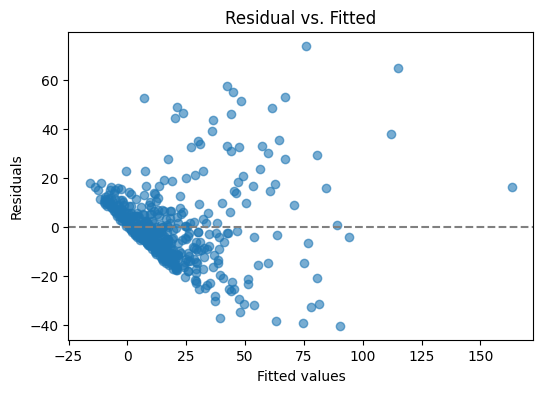

In [169]:

resid = best_model.resid
fitted = best_model.fittedvalues

plt.figure(figsize=(6,4))
plt.scatter(fitted, resid, alpha=0.6)
plt.axhline(0, color="grey", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residual vs. Fitted")
plt.show()

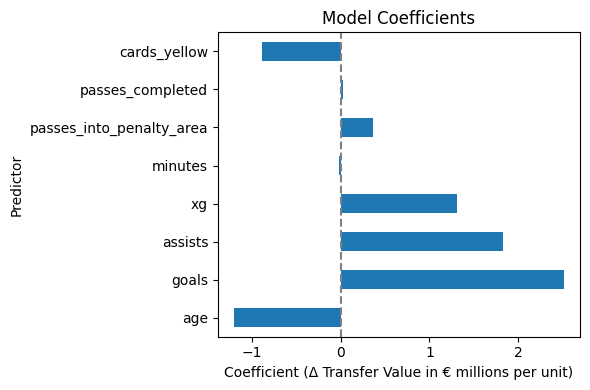

In [170]:

actual = fw["value_m_eur"]
pred = best_model.fittedvalues

plt.figure(figsize=(6,4))
coef = best_model.params.drop("const")
coef.plot(kind="barh")
plt.xlabel("Coefficient (Δ Transfer Value in € millions per unit)")
plt.ylabel("Predictor")
plt.title("Model Coefficients")
plt.axvline(0, color="grey", linestyle="--")
plt.tight_layout()
plt.show()

In [171]:
coefs = best_model.params.drop("const")
top5 = coefs.abs().sort_values(ascending=False)
print("\nTop predictors by |coef|:")
for name, _ in top5.items():
    print(f"{name}: {coefs[name]:.3f}")


Top predictors by |coef|:
goals: 2.511
assists: 1.825
xg: 1.313
age: -1.200
cards_yellow: -0.892
passes_into_penalty_area: 0.361
passes_completed: 0.023
minutes: -0.021


## Key Drivers of Transfer Value

- **goals**: +2.51 M€ per extra goal  
- **assists**: +1.83 M€ per extra assist  
- **xg**: +1.31 M€ per extra expected goal  
- **age**: –1.20 M€ per additional year  
- **cards_yellow**: –0.89 M€ per yellow card  
- **passes_into_penalty_area**: +0.36 M€ per extra entry  
- **passes_completed**: +0.02 M€ per completed pass  
- **minutes**: –0.02 M€ per extra minute played  

**Interpretation**  
- Scoring (goals, assists, xG) heavily boosts value  
- Older players & poor discipline (yellows) shave off value  
- More entries into the box help, but marginally  
- Minutes and pass success have tiny per-unit effects